In [246]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from scipy import stats
from scipy.stats import skew,norm 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


from tensorflow.keras.layers import Conv2D,LSTM,LeakyReLU, MaxPooling2D,Concatenate,Input, Dropout, Flatten, Dense, GlobalAveragePooling2D,Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model

pd.set_option('display.max_rows',50)
%matplotlib inline

# Best result:

##  With XGBClassifier, achieved AUC = 0.90 for testing data, AUC = 0.93 for training data

In [49]:
path = 'F://Python//Kaggle//higgs_boson'
os.chdir(path)

Data = pd.read_csv('training.csv')

In [67]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   EventId                      250000 non-null  int64  
 1   DER_mass_MMC                 250000 non-null  float64
 2   DER_mass_transverse_met_lep  250000 non-null  float64
 3   DER_mass_vis                 250000 non-null  float64
 4   DER_pt_h                     250000 non-null  float64
 5   DER_deltaeta_jet_jet         250000 non-null  float64
 6   DER_mass_jet_jet             250000 non-null  float64
 7   DER_prodeta_jet_jet          250000 non-null  float64
 8   DER_deltar_tau_lep           250000 non-null  float64
 9   DER_pt_tot                   250000 non-null  float64
 10  DER_sum_pt                   250000 non-null  float64
 11  DER_pt_ratio_lep_tau         250000 non-null  float64
 12  DER_met_phi_centrality       250000 non-null  float64
 13 

In [68]:
Data.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,224999.500000,-49.023079,49.239819,81.181982,57.895962,-708.420675,-601.237051,-709.356603,2.373100,18.917332,...,209.797178,0.979176,-348.329567,-399.254314,-399.259788,-692.381204,-709.121609,-709.118631,73.064591,1.646767
std,72168.927986,406.345647,35.344886,40.828691,63.655682,454.480565,657.972302,453.019877,0.782911,22.273494,...,126.499506,0.977426,532.962789,489.338286,489.333883,479.875496,453.384624,453.389017,98.015662,1.875103
min,100000.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,...,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.001502
25%,162499.750000,78.100750,19.241000,59.388750,14.068750,-999.000000,-999.000000,-999.000000,1.810000,2.841000,...,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.018636
50%,224999.500000,105.012000,46.524000,73.752000,38.467500,-999.000000,-999.000000,-999.000000,2.491500,12.315500,...,179.739000,1.000000,38.960000,-1.872000,-2.093000,-999.000000,-999.000000,-999.000000,40.512500,1.156188
75%,287499.250000,130.606250,73.598000,92.259000,79.169000,0.490000,83.446000,-4.593000,2.961000,27.591000,...,263.379250,2.000000,75.349000,0.433000,0.503000,33.703000,-2.457000,-2.275000,109.933750,2.404128
max,349999.000000,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,...,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000,7.822543


<AxesSubplot:>

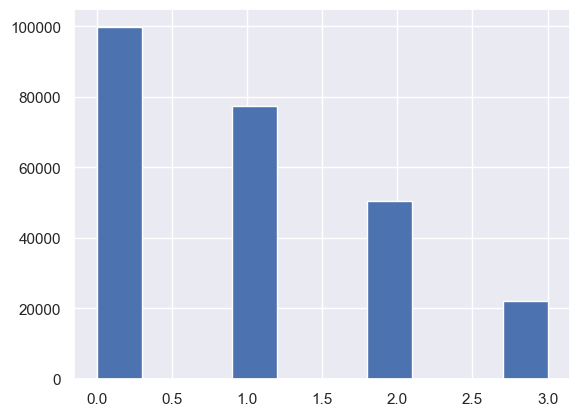

In [51]:
Data['PRI_jet_num'].hist()

In [60]:
A = Data.groupby(['PRI_jet_num']).mean()
A['Label']
# as it is not linearly dependent, maybe need to catogories?

PRI_jet_num
0    0.255142
1    0.357346
2    0.510808
3    0.303691
Name: Label, dtype: float64

<AxesSubplot:>

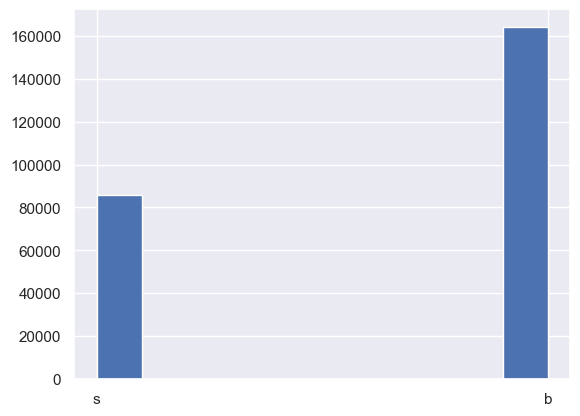

In [52]:
Data['Label'].hist()
# inbalanced data, need to balance the data before training

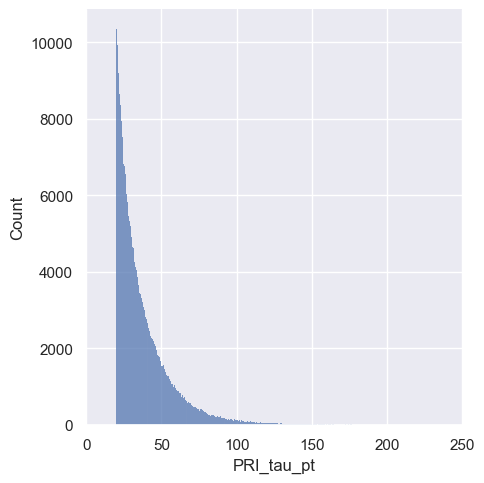

<Figure size 640x480 with 0 Axes>

In [53]:
sns.displot(Data['PRI_tau_pt'])
plt.xlim([0,250])
fig = plt.figure()
#stats.probplot(train['PRI_tau_pt'], plot=plt)

(0.0, 4.0)

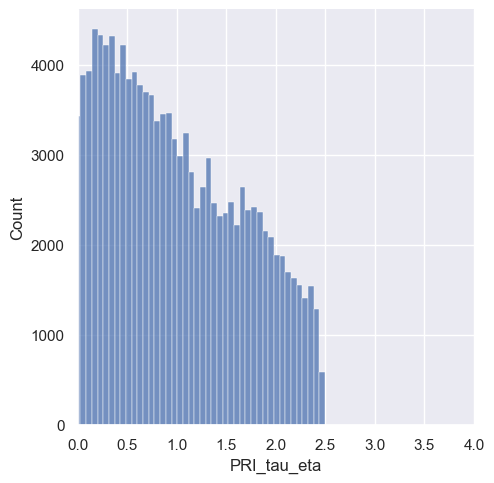

In [54]:
sns.displot(Data['PRI_tau_eta'])
plt.xlim([0,4])

<AxesSubplot:>

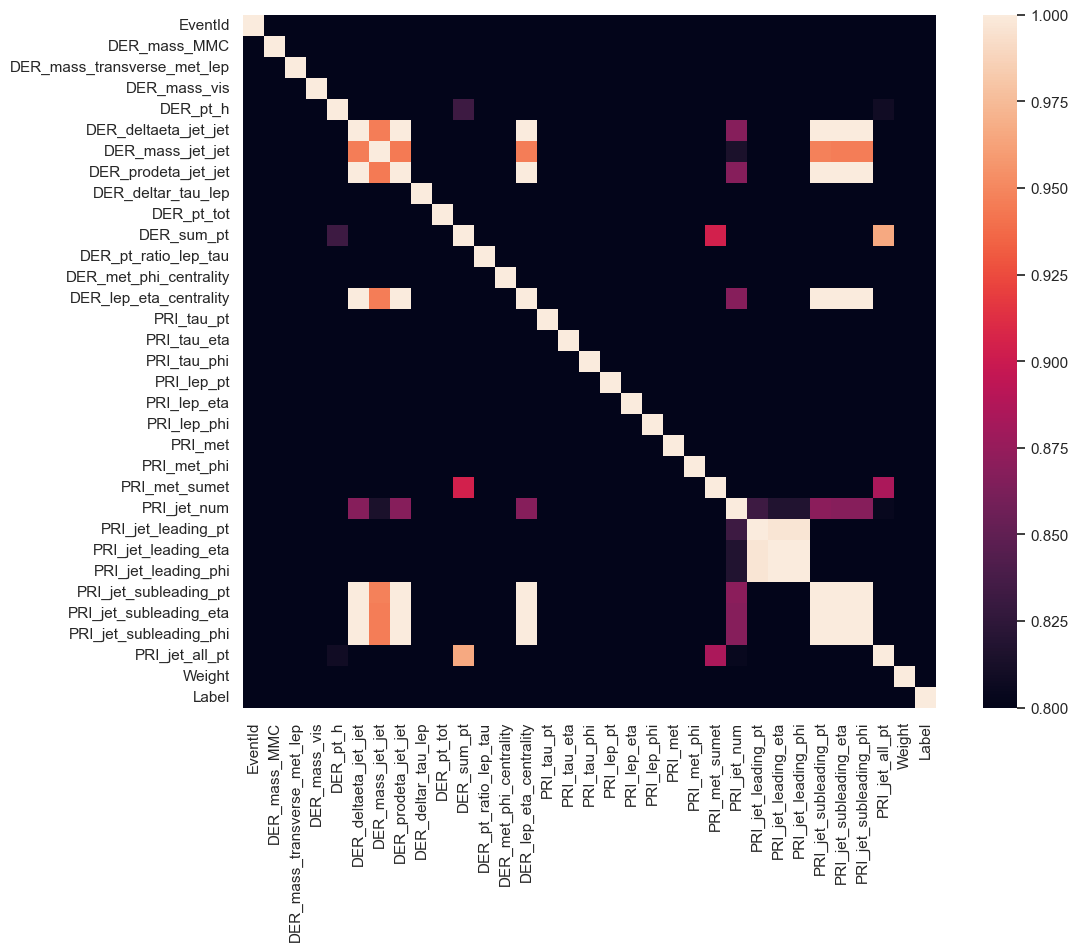

In [55]:
Data['Label'] = Data['Label'].map({'s':1, 'b':0})
corr_mat = Data.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, vmax = 1, vmin = 0.8, square = True)

## 1. Plot normalized distributions of features in the datasets for signal vs background
- notice some features have -1000 value, these are missing values. Discard these features as they contain over 10% missing value.

### Some features has significant different distribution for signal vs background: 

### Some features has similar distribution for signal vs background: 


In [165]:
Data = pd.read_csv('training.csv')

# map s -> 1 ; b-> 0
Y_Data = Data['Label'].map({'s':1, 'b':0})

Data_signal = Data.loc[Data['Label'] == 's']
Data_background = Data.loc[Data['Label'] == 'b']

Data = Data.drop(['Weight','EventId'], axis=1)

In [198]:
# label the missing value
Data.replace(to_replace = -999, value = np.nan, inplace = True)
(Data.isna().sum()[Data.isna().sum() > 0] / len(Data))

Series([], dtype: float64)

In [195]:
cols_drop = [
    'DER_deltaeta_jet_jet',
    'DER_mass_jet_jet',
    'DER_prodeta_jet_jet',
    'DER_lep_eta_centrality',
    'PRI_jet_subleading_pt',
    'PRI_jet_subleading_eta',
    'PRI_jet_subleading_phi',
    'PRI_jet_leading_pt',
    'PRI_jet_leading_eta',
    'PRI_jet_leading_phi',
    'DER_mass_MMC'
]

Data = Data.drop(cols_drop, axis=1)

In [196]:
for i in Data.columns:
    print(i)

DER_mass_transverse_met_lep
DER_mass_vis
DER_pt_h
DER_deltar_tau_lep
DER_pt_tot
DER_sum_pt
DER_pt_ratio_lep_tau
DER_met_phi_centrality
PRI_tau_pt
PRI_tau_eta
PRI_tau_phi
PRI_lep_pt
PRI_lep_eta
PRI_lep_phi
PRI_met
PRI_met_phi
PRI_met_sumet
PRI_jet_num
PRI_jet_all_pt
Label


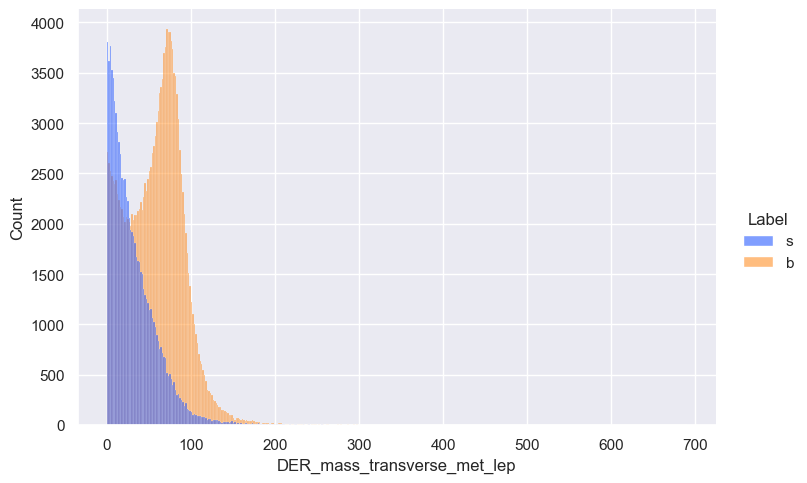

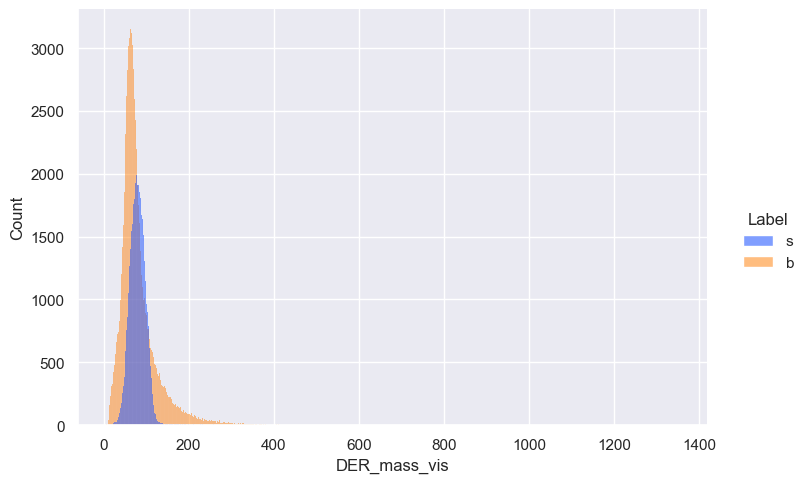

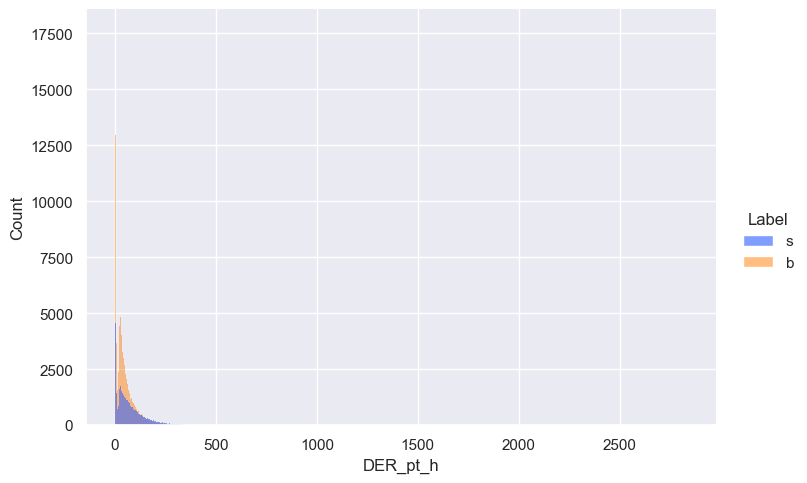

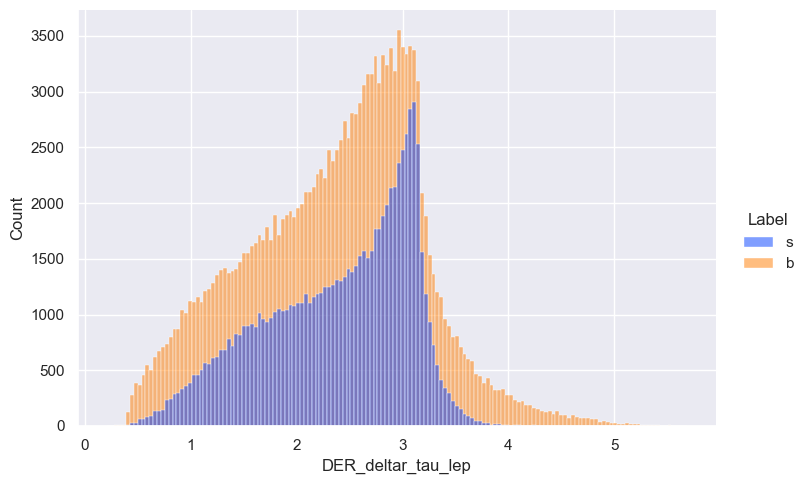

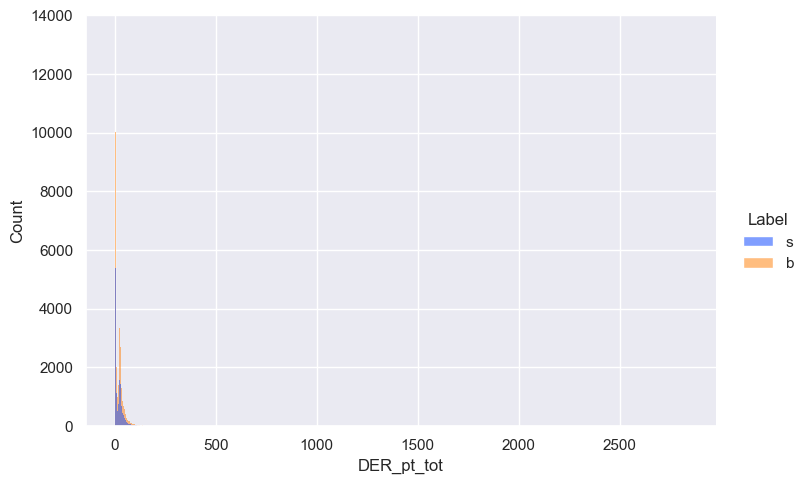

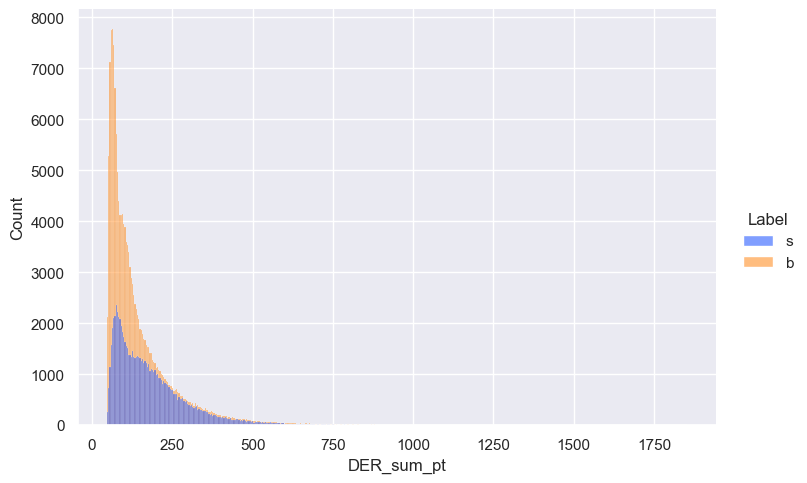

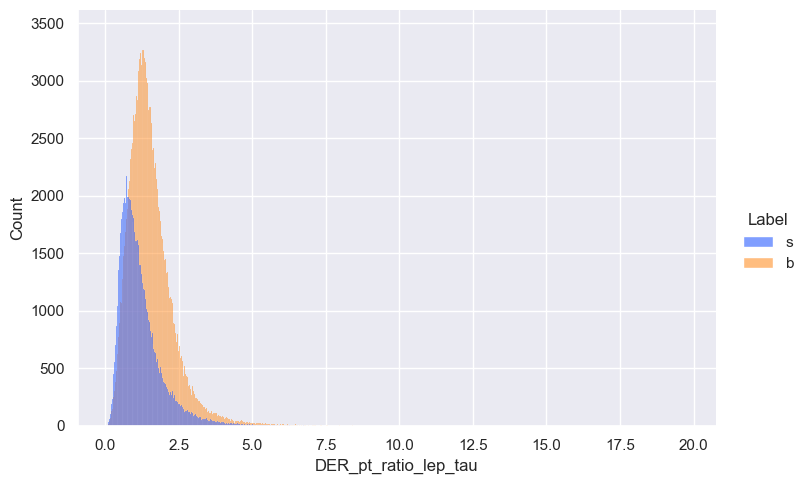

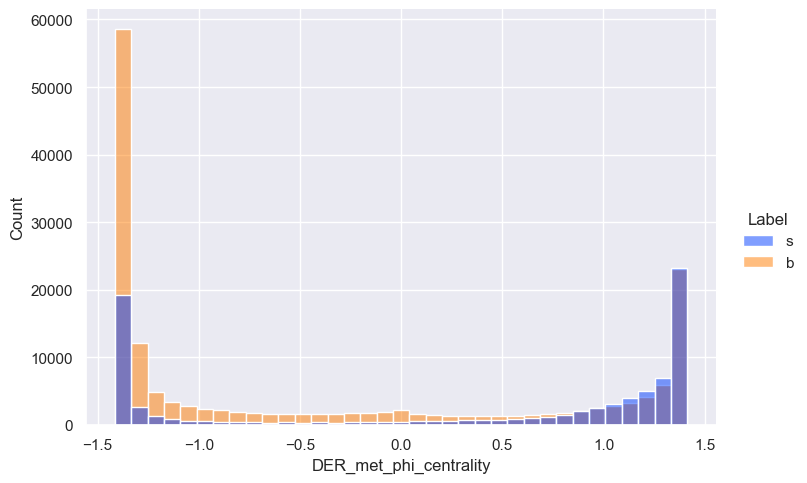

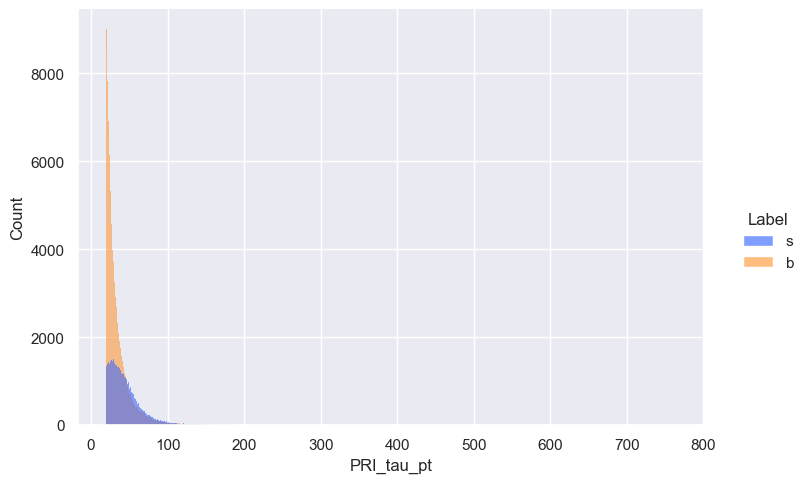

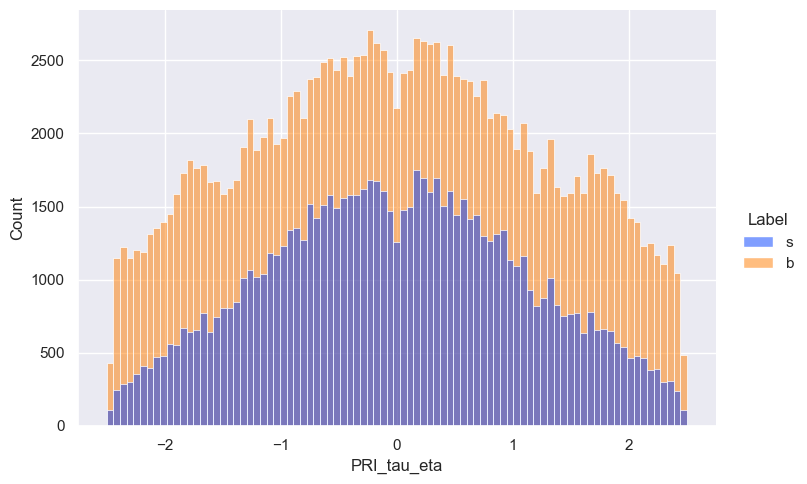

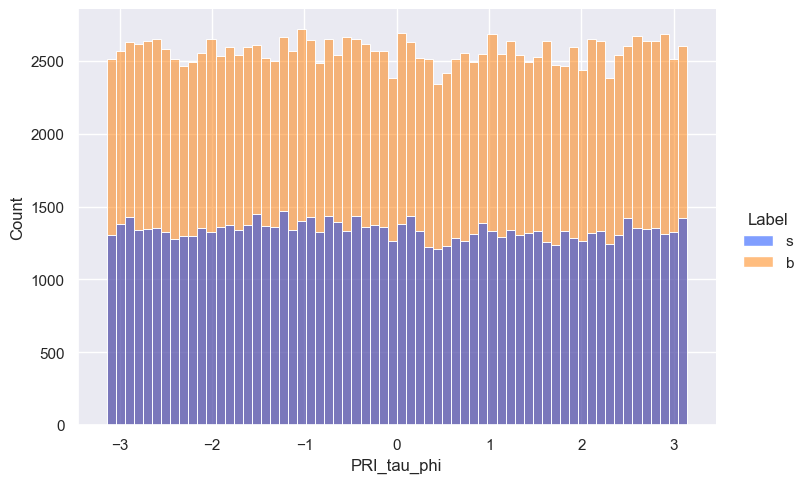

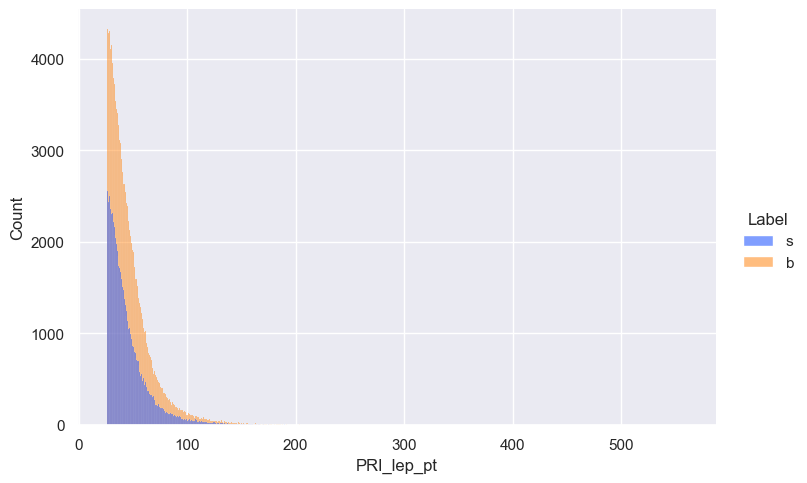

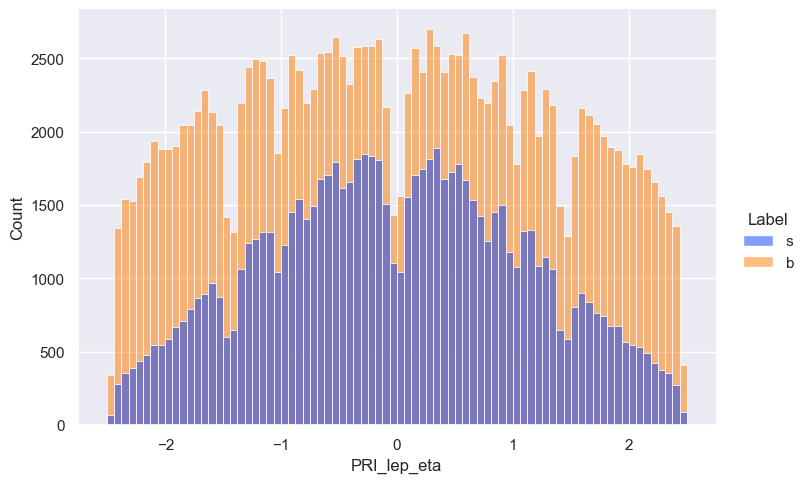

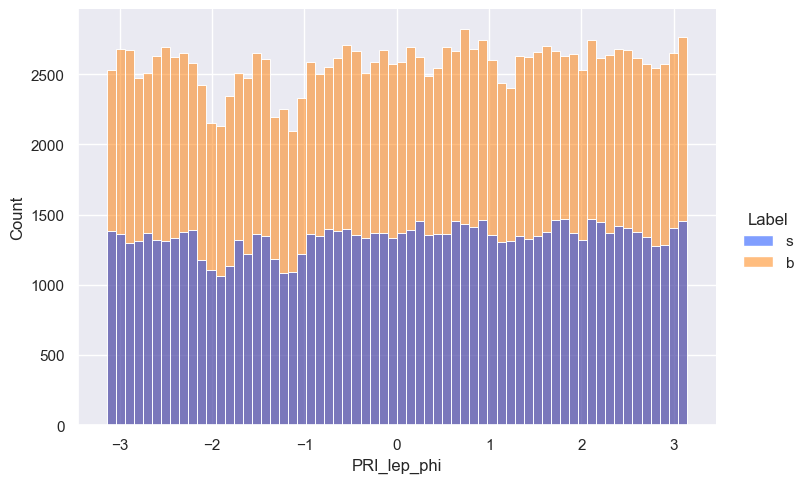

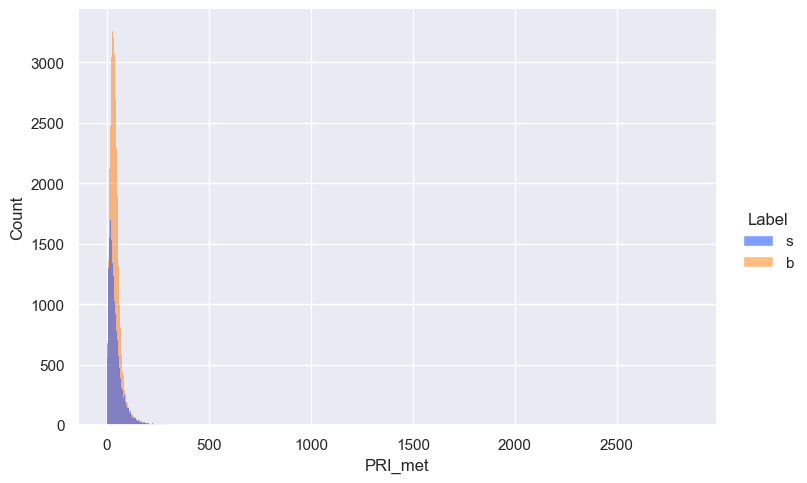

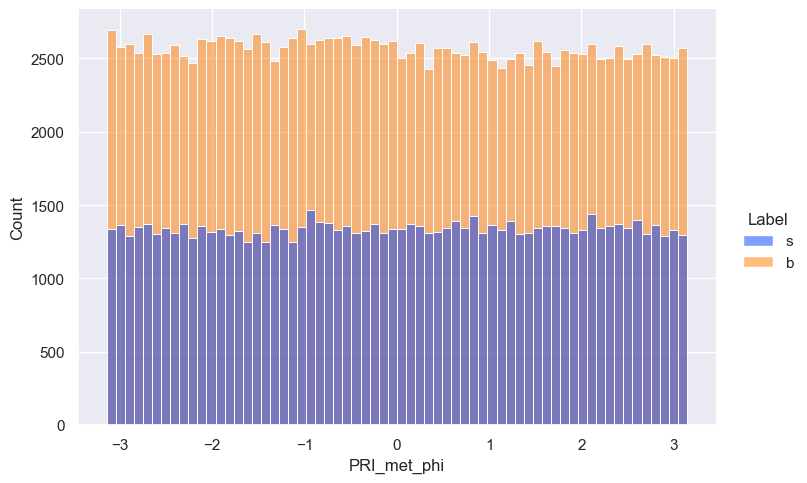

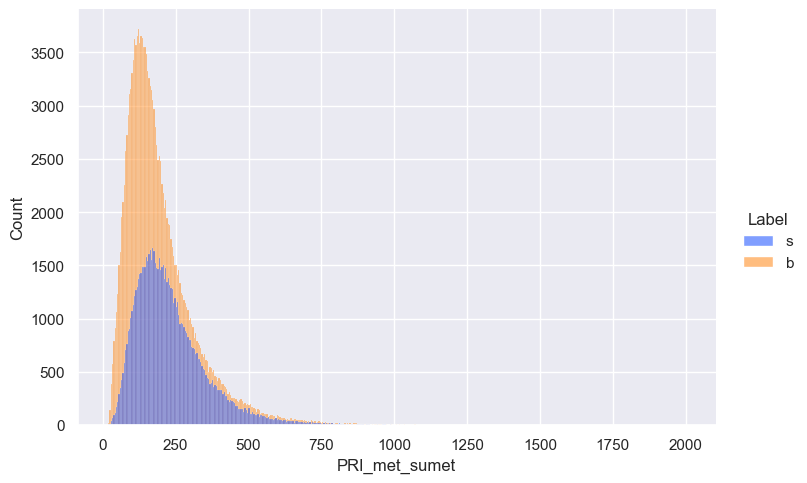

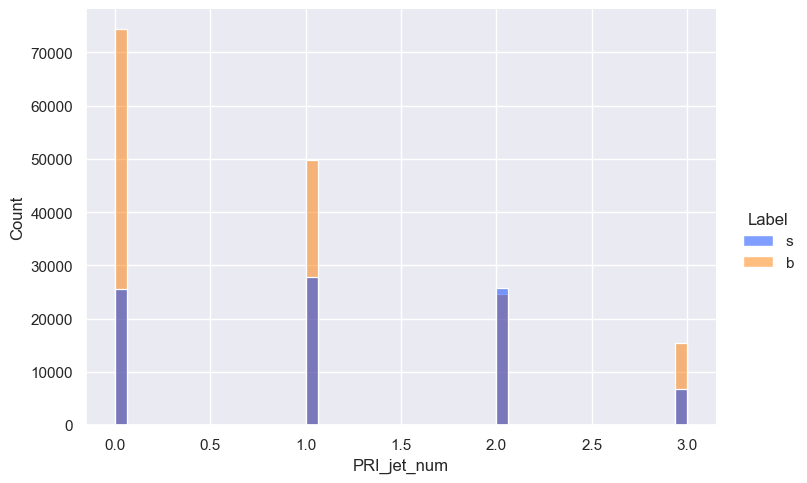

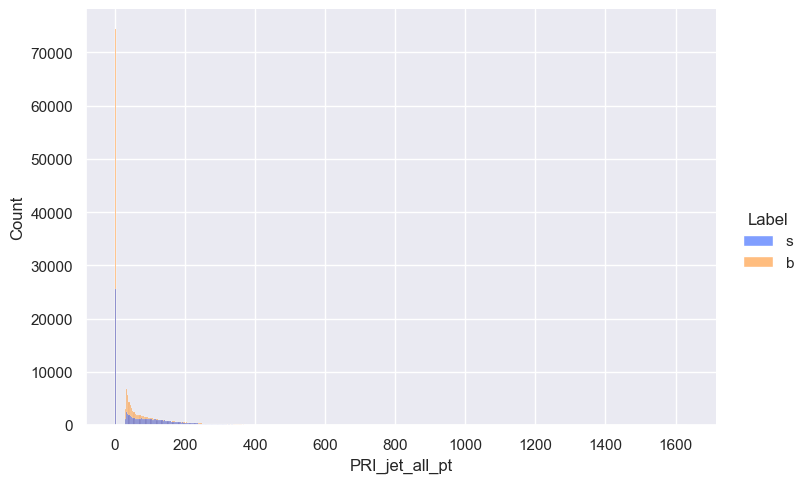

In [197]:
for i in range(len(Data.columns)-1):
    sns.displot(data=Data, x = Data.columns[i], hue='Label', kind='hist', fill=True, palette=sns.color_palette('bright')[:2], height=5, aspect=1.5)

## Prepare training and testing data

In [200]:
#Data = pd.read_csv('training.csv')

# map s -> 1 ; b-> 0
# Y_Data = Data['Label'].map({'s':1, 'b':0})
# Event_Id_train = train['EventId']
# X_Data = Data.drop(['Label','Weight','EventId'], axis=1)
X_Data = Data.drop(['Label'], axis=1)

X_Data = StandardScaler().fit_transform(X_Data)

X_train, X_test, Y_train, Y_test = train_test_split(X_Data, Y_Data, test_size=0.33, random_state=42)

In [201]:
print('Train data shape:', X_train.shape)
print('Test data shape:', X_test.shape)

Train data shape: (167500, 19)
Test data shape: (82500, 19)


## Logistic regression
### logistic regression classifier, w/wo L1/L2 penalty

In [202]:
Logistic_model = LogisticRegression(max_iter=4000)

Logistic_model.fit(X_train,Y_train)

LogisticRegression(max_iter=4000)

In [203]:
def clf_performance(classifier, model_name):
    print(model_name);
    print('Best Score:' + str(classifier.best_score_))
    print('Best Parameters' + str(classifier.best_params_))

In [213]:
# cross validation
lr = LogisticRegression()
param_grid = {'max_iter' : [1000],
              'penalty' : ['l1', 'l2'],
              'solver' : ['saga']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_train,Y_train)

print(best_clf_lr)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'max_iter': [1000], 'penalty': ['l1', 'l2'],
                         'solver': ['saga']},
             verbose=True)


In [212]:
clf_performance(best_clf_lr,'Logistic Regression')
print(best_clf_lr)

Logistic Regression
Best Score:0.7387283582089553
Best Parameters{'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'max_iter': [1000], 'penalty': ['l1', 'l2'],
                         'solver': ['saga']},
             verbose=True)


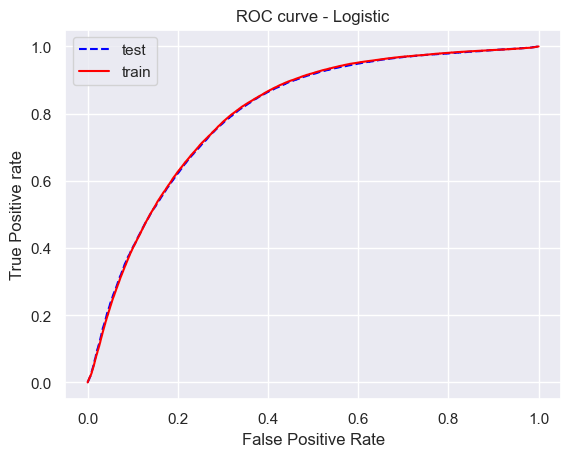

Logistic: AUC score for train data >>  0.8015069954454299
Logistic: AUC score for test data >> >>  0.8004426066320777


In [243]:
log_test_prob = best_clf_lr.predict_proba(X_test)
log_train_prob = best_clf_lr.predict_proba(X_train)

fpr_test, tpr_test, thresh_test = roc_curve(Y_test, log_test_prob[:,1], pos_label=1)
fpr_train, tpr_train, thresh_train = roc_curve(Y_train, log_train_prob[:,1], pos_label=1)

plt.plot(fpr_test, tpr_test, linestyle='--',color='blue', label='test')
plt.plot(fpr_train, tpr_train, linestyle='-',color='red', label='train')
plt.legend(loc='best')

plt.title('ROC curve - Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.show()

print('Logistic: AUC score for train data >> ', roc_auc_score(Y_train, log_train_prob[:,1]))
print('Logistic: AUC score for test data >> >> ', roc_auc_score(Y_test, log_test_prob[:,1]))

# XGBoost

In [214]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state = 100)
cv = cross_val_score(xgb,X_train,Y_train,cv=5)
print(cv)

print(cv.mean())

[0.83226866 0.82850746 0.82779104 0.8259403  0.82444776]
0.8277910447761194


In [217]:
xgb.fit(X_train,Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

In [245]:
#xgb.plot_importance(bst)
#plt.show()

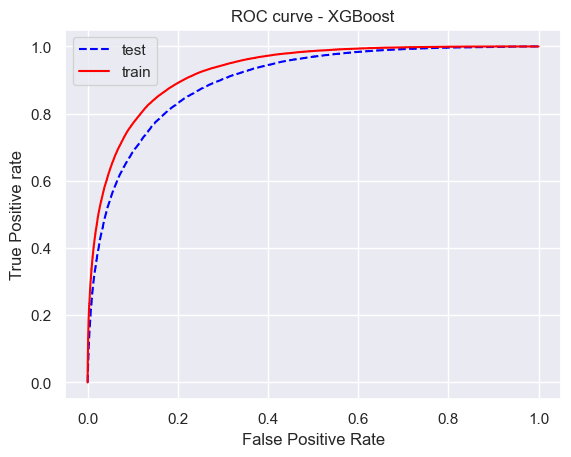

XGBoost: AUC score for train data >>  0.9277826952597008
XGBoost: AUC score for test data >>  0.8979658485184696


In [244]:
xgb_test_prob = xgb.predict_proba(X_test)
xgb_train_prob = xgb.predict_proba(X_train)

fpr_test, tpr_test, thresh_test = roc_curve(Y_test, xgb_test_prob[:,1], pos_label=1)
fpr_train, tpr_train, thresh_train = roc_curve(Y_train, xgb_train_prob[:,1], pos_label=1)

plt.plot(fpr_test, tpr_test, linestyle='--',color='blue', label='test')
plt.plot(fpr_train, tpr_train, linestyle='-',color='red', label='train')
plt.legend(loc='best')

plt.title('ROC curve - XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.show()

print('XGBoost: AUC score for train data >> ', roc_auc_score(Y_train, xgb_train_prob[:,1]))
print('XGBoost: AUC score for test data >> ', roc_auc_score(Y_test, xgb_test_prob[:,1]))

# DNN(deep neural network)

In [274]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-3,
                   hidden_layer_sizes=(5, 2), random_state=100, max_iter = 10000)

clf.fit(X_train,Y_train)

MLPClassifier(alpha=0.001, hidden_layer_sizes=(5, 2), max_iter=10000,
              random_state=100, solver='lbfgs')

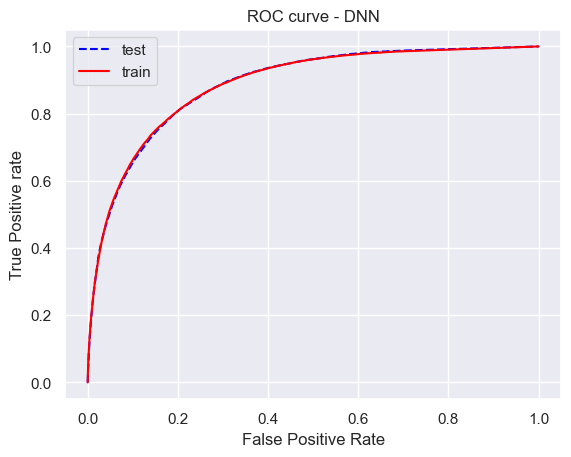

DNN: AUC score for train data >>  0.886221665475733
DNN: AUC score for test data >>  0.8859974133485946


In [276]:
dnn_test_prob = clf.predict_proba(X_test)
dnn_train_prob = clf.predict_proba(X_train)

fpr_test, tpr_test, thresh_test = roc_curve(Y_test, dnn_test_prob[:,1], pos_label=1)
fpr_train, tpr_train, thresh_train = roc_curve(Y_train, dnn_train_prob[:,1], pos_label=1)

plt.plot(fpr_test, tpr_test, linestyle='--',color='blue', label='test')
plt.plot(fpr_train, tpr_train, linestyle='-',color='red', label='train')
plt.legend(loc='best')

plt.title('ROC curve - DNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.show()

print('DNN: AUC score for train data >> ', roc_auc_score(Y_train, dnn_train_prob[:,1]))
print('DNN: AUC score for test data >> ', roc_auc_score(Y_test, dnn_test_prob[:,1]))